잡케어추천알고리즘경진대회
--

In [1]:
import pandas as pd

train=pd.read_csv("C:/Users/bella/Desktop/SelfStudy/데이콘/Jobcare_data/train_1.csv")

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.rcParams['font.family'] = 'NanumGothic'

1차 모델링 - 회귀, 딥러닝 시도해보기
--

In [4]:
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier 
from catboost import CatBoostClassifier
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn import metrics
from sklearn.model_selection import cross_val_score
from sklearn.metrics import r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import GridSearchCV
from sklearn import svm
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split

In [5]:
x=train.drop("target", axis=1)
y=train[["target"]]
x_train, x_test, y_train, y_test=train_test_split(x, y, test_size=0.2, random_state=42)

Regressor model로 접근해보기
--

In [7]:
from catboost import CatBoostRegressor

cbr = CatBoostRegressor(random_state=42)
cbr.fit(x_train, y_train)
y_pred=cbr.predict(x_test)
#train_score=cbr.score(x_train, y_train)
#test_score=cbr.score(x_test, y_test)

In [8]:
y_pred=pd.DataFrame(data=y_pred, columns=["target"])

In [9]:
y_pred["target"]=y_pred["target"].apply(lambda x:1 if x>=0.5 else 0)

In [10]:
f_1=f1_score(y_test, y_pred)

In [26]:
print(f"f1_score : {f_1}")

f1_score : 0.674687448496692


- catboost의 경우, classifer가 미세하게 더 높음

In [28]:
from xgboost import XGBRegressor

xgb = XGBRegressor(random_state=42)
xgb.fit(x_train, y_train)
y_pred=xgb.predict(x_test)
y_pred=pd.DataFrame(data=y_pred, columns=["target"])
y_pred["target"]=y_pred["target"].apply(lambda x:1 if x>=0.5 else 0)
f_1=f1_score(y_test, y_pred)
print(f"f1_score : {f_1}")

f1_score : 0.6734576656624741


- xgboost의 경우, regressor가 더 높음 (0.01 정도)

In [11]:
def reg_result(model, x_train, x_test, y_train, y_test):
    model.fit(x_train, y_train)
    y_pred=model.predict(x_test)
    y_pred=pd.DataFrame(data=y_pred, columns=["target"])
    y_pred["target"]=y_pred["target"].apply(lambda x:1 if x>=0.5 else 0)
    f_1=f1_score(y_test, y_pred)
    print(f"f1_score : {f_1}")

In [31]:
from lightgbm import LGBMRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor

rfr = RandomForestRegressor(random_state=42)
gbr = GradientBoostingRegressor(random_state=42)
lgbmr = LGBMRegressor(random_state=42)

In [32]:
reg_result(lgbmr, x_train, x_test, y_train, y_test)

f1_score : 0.6644309719304946


- LGBM의 경우, Classifier가 아주 미세하기 높음. (사실상 무의미한 차이, 0.002)

In [34]:
reg_result(gbr, x_train, x_test, y_train, y_test)

f1_score : 0.635317696903581


- gradient boost의 경우, classifier가 더 좋음 (0.03 정도)

In [36]:
#reg_result(rfr, x_train, x_test, y_train, y_test)

- 너무 오래 걸림

Multi-Layer Perceptron으로 접근
--

In [29]:
import tensorflow as tf
from keras.models import Sequential 
from keras.layers import Dense
import numpy

mm=MinMaxScaler()

x=mm.fit_transform(x)
y=train["target"]

In [30]:
x_train, x_test, y_train, y_test=train_test_split(x, y, test_size=0.2, random_state=42)

In [31]:
model=Sequential() #모델 불러오기
model.add(Dense(30, input_dim=60, activation='relu')) # 모델의 2층 옵션
model.add(Dense(1, activation='sigmoid')) # 모델의 1층 옵션

In [32]:
from keras import backend as K

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

- 참고한 자료: https://datascience.stackexchange.com/questions/45165/how-to-get-accuracy-f1-precision-and-recall-for-a-keras-model

In [33]:
model.compile(loss="binary_crossentropy", optimizer='adam', metrics=["acc", f1_m, precision_m, recall_m])

- 참고한 자료: https://aakashgoel12.medium.com/how-to-add-user-defined-function-get-f1-score-in-keras-metrics-3013f979ce0d

In [39]:
history = model.fit(x_train, y_train,  epochs=10)

In [35]:
y_pred=model.predict(x_test)

In [38]:
y_pred=pd.DataFrame(data=y_pred, columns=["target"])
y_pred["target"]=y_pred["target"].apply(lambda x:1 if x>=0.5 else 0)
f_1=f1_score(y_test, y_pred)
print(f"f1_score : {f_1}")

f1_score : 0.6581828455724813


In [45]:
def check_f1_score(y_test, y_pred):
    y_pred=pd.DataFrame(data=y_pred, columns=["target"])
    y_pred["target"]=y_pred["target"].apply(lambda x:1 if x>=0.5 else 0)
    f_1=f1_score(y_test, y_pred)
    print(f"f1_score : {f_1}")

In [50]:
from keras.layers import Dropout
from keras.layers import BatchNormalization

In [51]:
model = Sequential()
model.add(Dense(512, activation='relu', input_shape=(60,)))
model.add(BatchNormalization())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(128, activation='relu'))
model.add(BatchNormalization())
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(32, activation='relu'))
model.add(BatchNormalization())
model.add(Dense(16, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(8, activation='relu'))
model.add(BatchNormalization())
model.add(Dense(4, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss="binary_crossentropy", optimizer='adam', metrics=["acc", f1_m, precision_m, recall_m])

In [52]:
history = model.fit(x_train, y_train,  epochs=30)

Epoch 1/30
12549/12549 [==============================] - 71s 6ms/step - loss: 0.6568 - acc: 0.6154 - f1_m: 0.6417 - precision_m: 0.6041 - recall_m: 0.7091
Epoch 2/30
12549/12549 [==============================] - 72s 6ms/step - loss: 0.6346 - acc: 0.6379 - f1_m: 0.6484 - precision_m: 0.6312 - recall_m: 0.6844
Epoch 3/30
12549/12549 [==============================] - 70s 6ms/step - loss: 0.6317 - acc: 0.6404 - f1_m: 0.6509 - precision_m: 0.6336 - recall_m: 0.6871
Epoch 4/30
12549/12549 [==============================] - 82s 7ms/step - loss: 0.6296 - acc: 0.6432 - f1_m: 0.6536 - precision_m: 0.6351 - recall_m: 0.6909
Epoch 5/30
12549/12549 [==============================] - 73s 6ms/step - loss: 0.6292 - acc: 0.6436 - f1_m: 0.6539 - precision_m: 0.6354 - recall_m: 0.6911
Epoch 6/30
12549/12549 [==============================] - 65s 5ms/step - loss: 0.6293 - acc: 0.6434 - f1_m: 0.6551 - precision_m: 0.6345 - recall_m: 0.6943
Epoch 7/30
12549/12549 [==============================] - 64s 5m

In [53]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_9 (Dense)             (None, 512)               31232     
                                                                 
 batch_normalization (BatchN  (None, 512)              2048      
 ormalization)                                                   
                                                                 
 dense_10 (Dense)            (None, 256)               131328    
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_11 (Dense)            (None, 128)               32896     
                                                                 
 batch_normalization_1 (Batc  (None, 128)              512       
 hNormalization)                                      

In [54]:
y_pred=model.predict(x_test)

In [55]:
check_f1_score(y_test, y_pred)

f1_score : 0.6841896075642205


In [56]:
print("\n Train Accuracy %.4f"%(model.evaluate(x_train, y_train)[1]))

12549/12549 [==============================] - 26s 2ms/step - loss: 0.5842 - acc: 0.7022 - f1_m: 0.6792 - precision_m: 0.7239 - recall_m: 0.6529

 Train Accuracy 0.7022


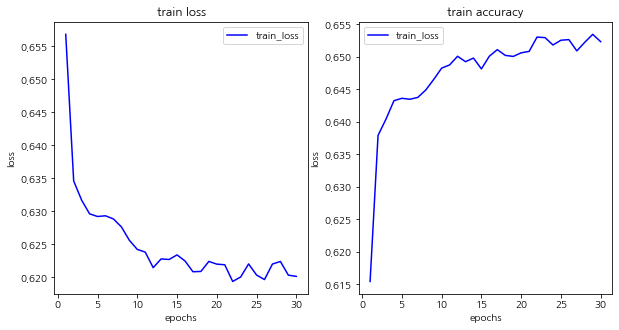

In [58]:
import matplotlib.pyplot as plt

his_dict = history.history
loss = his_dict['loss']
acc = his_dict['acc']

epochs = range(1,len(loss)+1 )
fig = plt.figure(figsize= (10,5) )

# 학습 및 검증 손실 그리기

ax1 = fig.add_subplot(1,2,1)
ax1.plot(epochs, loss, color = 'blue', label = 'train_loss')
ax1.set_title('train loss')
ax1.set_xlabel('epochs')
ax1.set_ylabel('loss')
ax1.legend()

# 학습 및 검증 정확도 그리기
ax2 = fig.add_subplot(1,2,2)
ax2.plot(epochs, acc, color = 'blue', label = 'train_loss')
ax2.set_title('train accuracy')
ax2.set_xlabel('epochs')
ax2.set_ylabel('loss')
ax2.legend()


plt.show()

**1차 모델링 f1-score 점검**

**Classification**

- CATBOOST Classifier: 0.68416

**Regression**

- CATBOOST Regressor: 0.67468

**MLP**

- MLP: 0.68418


**Result**

- 현재까지는 MLP가 아주 미세한 차이로 가장 좋음.


Classifier로 다시 접근
--

처음 받았던 데이터로 시도해보기

In [67]:
x=train.drop(['match_yn', 'match_yn_d', 'match_yn_h', '속성 D 코드', '속성 D 세분류코드_x', '속성 D 소분류코드_x', '속성 D 중분류코드_x',
       '속성 D 대분류코드_x', '속성 H 코드', '속성 H 중분류코드_x', '속성 H 대분류코드_x',
       '속성 D 세분류코드_y', '속성 D 소분류코드_y', '속성 D 중분류코드_y', '속성 D 대분류코드_y',
       '속성 H 중분류코드_y', '속성 H 대분류코드_y', '속성 L 코드', '속성 L 세분류코드', '속성 L 소분류코드',
       '속성 L 중분류코드', '속성 L 대분류코드', 'target' ], axis=1)
y=train["target"]

In [17]:
cb = CatBoostClassifier(random_state=42)

In [69]:
x_train, x_test, y_train, y_test=train_test_split(x, y, test_size=0.2, random_state=42)

In [72]:
cb.fit(x_train, y_train)
y_pred=cb.predict(x_test)
train_score=cb.score(x_train, y_train)
test_score=cb.score(x_test, y_test)
f_1=f1_score(y_test, y_pred)

In [71]:
print(train_score, test_score, f_1)

0.7536632134674769 0.7259515295195784 0.6841114198452247


- 큰 차이 없음 전: 0.68416 -> 후: 0.68411

In [78]:
x=train.drop(['match_yn', 'match_yn_d', 'match_yn_h', 'target' ], axis=1)
y=train["target"]

In [79]:
x_train, x_test, y_train, y_test=train_test_split(x, y, test_size=0.2, random_state=42)

In [82]:
cb.fit(x_train, y_train)
y_pred=cb.predict(x_test)
train_score=cb.score(x_train, y_train)
test_score=cb.score(x_test, y_test)
f_1=f1_score(y_test, y_pred)

In [81]:
print(train_score, test_score, f_1)

0.7528165155892022 0.7266687252841391 0.684713668535711


- 가장 결과가 좋음

- 전: 0.68416 -> 0.68471

In [83]:
train.drop(['match_yn', 'match_yn_d', 'match_yn_h'], axis=1, inplace=True)

Scaling
--

In [115]:
from sklearn.preprocessing import RobustScaler

mm=MinMaxScaler()
rr=RobustScaler()
ss=StandardScaler()

In [116]:
x=train.drop("target", axis=1)
y=train["target"]

In [117]:
x_m=mm.fit_transform(x)
x_r=rr.fit_transform(x)
x_s=ss.fit_transform(x)

In [118]:
def cb_result(model, x,y):
    x_train, x_test, y_train, y_test=train_test_split(x, y, test_size=0.2, random_state=42)
    cb.fit(x_train, y_train)
    y_pred=cb.predict(x_test)
    train_score=cb.score(x_train, y_train)
    test_score=cb.score(x_test, y_test)
    f_1=f1_score(y_test, y_pred)
    return train_score, test_score, f_1    

In [122]:
mm_result=cb_result(cb, x_m, y)

In [121]:
print("train_score", mm_result[0])
print("test_score", mm_result[1])
print("f1_score", mm_result[2])

train_score 0.7534390875585217
test_score 0.7260710621470052
f1_score 0.6843071977958902


- minmax scaler 결과는 더 떨어졌음

In [128]:
rr_result=cb_result(cb, x_r, y)

In [124]:
print("train_score", rr_result[0])
print("test_score", rr_result[1])
print("f1_score", rr_result[2])

train_score 0.7534390875585217
test_score 0.7259913737287207
f1_score 0.684106568672485


- robust scaler 역시 결과가 더 떨어졌음

In [127]:
ss_result=cb_result(cb, x_s, y)

In [126]:
print("train_score", ss_result[0])
print("test_score", ss_result[1])
print("f1_score", ss_result[2])

train_score 0.7530630540890527
test_score 0.7264296600292854
f1_score 0.6845973632229317


- scaling 안 해준 것보다 낮긴 하나 3가지 scaling 중에 가장 결과가 좋음

Column별 Scaling 해주기
--

- 잡케어추천알고리즘경진대회(1편)에서 EDA 과정중 categorical 하다고 보기 어려운 경우, kdeplot과 boxplot으로 살펴봤었다. 이 때 해당하는 칼럼들을 전부 standard scaling 해주기로 한다.

In [173]:
# ss=StandardScaler()
# ss=MinMaxScaler()
ss=RobustScaler()

In [174]:
train_2=train.copy()

In [175]:
train_2["person_prefer_d_1"]=ss.fit_transform(train_2[["person_prefer_d_1"]])
train_2["person_prefer_d_2"]=ss.fit_transform(train_2[["person_prefer_d_2"]])
train_2["person_prefer_d_3"]=ss.fit_transform(train_2[["person_prefer_d_3"]])

In [176]:
train_2["person_prefer_h_1"]=ss.fit_transform(train_2[["person_prefer_h_1"]])
train_2["person_prefer_h_2"]=ss.fit_transform(train_2[["person_prefer_h_2"]])
train_2["person_prefer_h_3"]=ss.fit_transform(train_2[["person_prefer_h_3"]])

In [177]:
train_2["contents_attribute_l"]=ss.fit_transform(train_2[["contents_attribute_l"]])
train_2["contents_attribute_d"]=ss.fit_transform(train_2[["contents_attribute_d"]])
train_2["contents_attribute_h"]=ss.fit_transform(train_2[["contents_attribute_h"]])

In [178]:
train_2["person_rn"]=ss.fit_transform(train_2[["person_rn"]])
train_2["contents_rn"]=ss.fit_transform(train_2[["contents_rn"]])

In [179]:
train_2['time']=ss.fit_transform(train_2[['time']])

In [180]:
for i in range(39,58):
    name=train_2.columns[i]
    train_2[name]=ss.fit_transform(train[[name]])

In [181]:
x=train_2.drop("target", axis=1)
y=train_2["target"]

In [184]:
result=cb_result(cb, x, y)

**Standard_Scaler로 칼럼별로 Scaling 한 결과**

In [159]:
print("train_score", result[0])
print("test_score", result[1])
print("f1_score", result[2])

train_score 0.7530829763920709
test_score 0.726439621081571
f1_score 0.6846921319418133


**MinMax_Scaler로 칼럼별로 Scaling한 결과**

In [172]:
print("train_score", result[0])
print("test_score", result[1])
print("f1_score", result[2])

train_score 0.7528165155892022
test_score 0.7266687252841391
f1_score 0.684713668535711


- 처음 Catboost 돌렸을떄랑 똑같음

**Robust_Scaler로 칼럼별로 Scaling한 결과**

In [183]:
print("train_score", result[0])
print("test_score", result[1])
print("f1_score", result[2])

train_score 0.75303815121028
test_score 0.7257722305784383
f1_score 0.6839918271769324


iforest로 이상치 탐지하기
--

In [214]:
train_2=train.copy()

In [215]:
from sklearn.ensemble import IsolationForest

col_list=["person_prefer_d_1","person_prefer_d_2","person_prefer_d_3","person_prefer_h_1",
         "person_prefer_h_2","person_prefer_h_3","contents_attribute_l","contents_attribute_d",
         "contents_attribute_h","person_rn","contents_rn"]

for i in range(39,58):
    name=train_2.columns[i]
    col_list.append(name)

In [216]:
from tqdm import tqdm

In [217]:
for i in tqdm((col_list)):
    iso = IsolationForest(max_samples=100, random_state=42)
    iso.fit(train_2[[i]])
    pred=iso.predict(train_2[[i]])
    scores=iso.decision_function(train_2[[i]])
    train_2[f"{i}_score"]=scores
    train_2[f"{i}_outlier"]=pred

100%|██████████| 30/30 [13:02<00:00, 26.10s/it]


- 코드 참고한 자료: https://www.kaggle.com/christianlillelund/tutorial-use-isolationforest-to-detect-outliers

- score: 1에 가까운 점수는 이상값을 나타낸다.

- score: 0.5보다 훨씬 작은 점수는 정상적인 관측값을 나타낸다.

- outlier:pred값이 -1인 경우, 이상 값, 1인 경우, 이상값이 아니다.

- 내용 참고한 자료: https://claryk.tistory.com/6


In [218]:
train_2

,id,d_l_match_yn,d_m_match_yn,d_s_match_yn,h_l_match_yn,h_m_match_yn,h_s_match_yn,person_attribute_a,person_attribute_a_1,person_attribute_b,...,속성 L 코드_score,속성 L 코드_outlier,속성 L 세분류코드_score,속성 L 세분류코드_outlier,속성 L 소분류코드_score,속성 L 소분류코드_outlier,속성 L 중분류코드_score,속성 L 중분류코드_outlier,속성 L 대분류코드_score,속성 L 대분류코드_outlier
0,0,1,1,1,2,2,2,1,4,3,...,0.011465,1,0.005242,1,0.000187,1,-0.022419,-1,-0.055846,-1
1,331621,1,1,1,2,2,2,1,7,3,...,0.011465,1,0.005242,1,0.000187,1,-0.022419,-1,-0.055846,-1
2,133244,1,1,1,2,2,2,1,6,5,...,0.011465,1,0.005242,1,0.000187,1,-0.022419,-1,-0.055846,-1
3,37130,2,2,2,1,1,1,1,4,2,...,0.011465,1,0.005242,1,0.000187,1,-0.022419,-1,-0.055846,-1
4,202316,1,2,2,1,2,2,1,3,4,...,0.011465,1,0.005242,1,0.000187,1,-0.022419,-1,-0.055846,-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
501946,461455,2,2,2,2,2,2,2,0,3,...,-0.049304,-1,-0.057733,-1,-0.046786,-1,-0.045494,-1,-0.148237,-1
501947,352731,1,1,1,2,2,2,1,6,2,...,-0.148736,-1,-0.149367,-1,-0.146669,-1,-0.124203,-1,-0.012385,-1
501948,224676,1,1,1,2,2,2,1,4,2,...,-0.148736,-1,-0.149367,-1,-0.146669,-1,-0.124203,-1,-0.012385,-1
501949,313755,2,2,2,1,2,2,2,6,2,...,-0.148736,-1,-0.149367,-1,-0.146669,-1,-0.124203,-1,-0.012385,-1


In [221]:
#train_2.to_csv("C:/Users/bella/Desktop/SelfStudy/데이콘/Jobcare_data/train_2.csv", index=False)

In [225]:
import numpy as np

In [246]:
for i in range(58, 118,2):
    name=train_2.columns[i]
    Q1=np.percentile(train_2[name], 25)
    Q3=np.percentile(train_2[name], 75)
    IQR=Q3-Q1
    outlier=train_2.loc[train_2[name]>Q3+(1.5*IQR)]
    print(name, ":", len(outlier))   

person_prefer_d_1_score : 0
person_prefer_d_2_score : 0
person_prefer_d_3_score : 0
person_prefer_h_1_score : 0
person_prefer_h_2_score : 0
person_prefer_h_3_score : 0
contents_attribute_l_score : 0
contents_attribute_d_score : 0
contents_attribute_h_score : 0
person_rn_score : 0
contents_rn_score : 0
속성 D 코드_score : 0
속성 D 세분류코드_x_score : 0
속성 D 소분류코드_x_score : 0
속성 D 중분류코드_x_score : 0
속성 D 대분류코드_x_score : 0
속성 H 코드_score : 0
속성 H 중분류코드_x_score : 0
속성 H 대분류코드_x_score : 0
속성 D 세분류코드_y_score : 0
속성 D 소분류코드_y_score : 0
속성 D 중분류코드_y_score : 0
속성 D 대분류코드_y_score : 0
속성 H 중분류코드_y_score : 0
속성 H 대분류코드_y_score : 0
속성 L 코드_score : 0
속성 L 세분류코드_score : 0
속성 L 소분류코드_score : 0
속성 L 중분류코드_score : 0
속성 L 대분류코드_score : 0


- Q3+(1.5*IQR) 이상인 데이터는 없다.

In [247]:
for i in range(59, 117,2):
    name=train_2.columns[i]
    outlier=train_2.loc[train_2[name]==-1]
    print(name, ":", len(outlier))   

person_prefer_d_1_outlier : 307943
person_prefer_d_2_outlier : 268172
person_prefer_d_3_outlier : 223191
person_prefer_h_1_outlier : 274536
person_prefer_h_2_outlier : 345135
person_prefer_h_3_outlier : 308056
contents_attribute_l_outlier : 234430
contents_attribute_d_outlier : 316258
contents_attribute_h_outlier : 241595
person_rn_outlier : 197569
contents_rn_outlier : 287314
속성 D 코드_outlier : 316258
속성 D 세분류코드_x_outlier : 347276
속성 D 소분류코드_x_outlier : 327225
속성 D 중분류코드_x_outlier : 243375
속성 D 대분류코드_x_outlier : 166830
속성 H 코드_outlier : 241595
속성 H 중분류코드_x_outlier : 268701
속성 H 대분류코드_x_outlier : 355619
속성 D 세분류코드_y_outlier : 300543
속성 D 소분류코드_y_outlier : 329048
속성 D 중분류코드_y_outlier : 253779
속성 D 대분류코드_y_outlier : 179878
속성 H 중분류코드_y_outlier : 243879
속성 H 대분류코드_y_outlier : 340363
속성 L 코드_outlier : 234430
속성 L 세분류코드_outlier : 240595
속성 L 소분류코드_outlier : 271069
속성 L 중분류코드_outlier : 276062


- outlier:pred값이 -1인 경우, 이상 값, 1인 경우, 이상값이 아니다.

- pred값이 -1인 데이터는 매우 많다..

In [331]:
for i in range(58, 118,2):
    name=train_2.columns[i]
    avg=train_2[name].mean()
    sd=train_2[name].std()
    outlier=train_2.loc[train_2[name]>avg+(3*sd)]
    print(name, ":", len(outlier))   

person_prefer_d_1_score : 0
person_prefer_d_2_score : 0
person_prefer_d_3_score : 0
person_prefer_h_1_score : 0
person_prefer_h_2_score : 0
person_prefer_h_3_score : 0
contents_attribute_l_score : 0
contents_attribute_d_score : 0
contents_attribute_h_score : 0
person_rn_score : 0
contents_rn_score : 0
속성 D 코드_score : 0
속성 D 세분류코드_x_score : 0
속성 D 소분류코드_x_score : 0
속성 D 중분류코드_x_score : 0
속성 D 대분류코드_x_score : 0
속성 H 코드_score : 0
속성 H 중분류코드_x_score : 0
속성 H 대분류코드_x_score : 0
속성 D 세분류코드_y_score : 0
속성 D 소분류코드_y_score : 0
속성 D 중분류코드_y_score : 0
속성 D 대분류코드_y_score : 0
속성 H 중분류코드_y_score : 0
속성 H 대분류코드_y_score : 0
속성 L 코드_score : 0
속성 L 세분류코드_score : 0
속성 L 소분류코드_score : 0
속성 L 중분류코드_score : 0
속성 L 대분류코드_score : 0


In [292]:
train_3=train_2.copy()

In [293]:
for i in range(59, 117,2):
    name=train_3.columns[i]
    train_3[name]=train_3[name].apply(lambda x:0 if x==1 else 1)

일단 딥러닝 한 번 더 try
--

In [306]:
x=train_3.drop("target", axis=1)
y=train_3["target"]

In [307]:
x=mm.fit_transform(x)

In [308]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

In [309]:
model = Sequential()
model.add(Dense(4096, activation='relu', input_shape=(117,)))
model.add(BatchNormalization())
model.add(Dense(2048, activation='relu'))
model.add(BatchNormalization())
model.add(Dense(1024, activation='relu'))
model.add(BatchNormalization())
model.add(Dense(512, activation='relu'))
model.add(BatchNormalization())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(128, activation='relu'))
model.add(BatchNormalization())
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(32, activation='relu'))
model.add(BatchNormalization())
model.add(Dense(16, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(8, activation='relu'))
model.add(BatchNormalization())
model.add(Dense(4, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss="binary_crossentropy", optimizer='adam', metrics=["acc", f1_m, precision_m, recall_m])

In [310]:
model.summary()

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_85 (Dense)            (None, 4096)              483328    
                                                                 
 batch_normalization_41 (Bat  (None, 4096)             16384     
 chNormalization)                                                
                                                                 
 dense_86 (Dense)            (None, 2048)              8390656   
                                                                 
 batch_normalization_42 (Bat  (None, 2048)             8192      
 chNormalization)                                                
                                                                 
 dense_87 (Dense)            (None, 1024)              2098176   
                                                                 
 batch_normalization_43 (Bat  (None, 1024)           

In [311]:
from keras.models import load_model

model.save('C:/Users/bella/Desktop/SelfStudy/데이콘/Jobcare_data/model/my_model.h5') # 모델 저장하기

In [312]:
from keras.callbacks import ModelCheckpoint, EarlyStopping

In [313]:
import os

In [314]:
MODEL_DIR='C:/Users/bella/Desktop/SelfStudy/데이콘/Jobcare_data/model/history/'
if not os.path.exists(MODEL_DIR):
    os.mkdir(MODEL_DIR)

modelpath="C:/Users/bella/Desktop/SelfStudy/데이콘/Jobcare_data/model/history/{epoch:02d}-{val_loss:.4f}.hdf5"
checkpointer=ModelCheckpoint(filepath=modelpath, monitor='val_loss', verbose=1, save_best_only=True)
early_stopping_callback=EarlyStopping(monitor='val_loss',patience=10)

In [315]:
%time
history = model.fit(x_train, y_train,
                    epochs = 20,
                    batch_size = 50,
                    validation_data = (x_test,y_test), callbacks=[early_stopping_callback, checkpointer])

Wall time: 0 ns
Epoch 1/20
8032/8032 [==============================] - ETA: 0s - loss: 0.6273 - acc: 0.6361 - f1_m: 0.6191 - precision_m: 0.6469 - recall_m: 0.6167
Epoch 00001: val_loss improved from inf to 0.56560, saving model to C:/Users/bella/Desktop/SelfStudy/데이콘/Jobcare_data/model/history\01-0.5656.hdf5
8032/8032 [==============================] - 921s 114ms/step - loss: 0.6273 - acc: 0.6361 - f1_m: 0.6191 - precision_m: 0.6469 - recall_m: 0.6167 - val_loss: 0.5656 - val_acc: 0.6833 - val_f1_m: 0.6114 - val_precision_m: 0.7833 - val_recall_m: 0.5089
Epoch 2/20
8032/8032 [==============================] - ETA: 0s - loss: 0.6050 - acc: 0.6609 - f1_m: 0.6506 - precision_m: 0.6736 - recall_m: 0.6410
Epoch 00002: val_loss improved from 0.56560 to 0.54470, saving model to C:/Users/bella/Desktop/SelfStudy/데이콘/Jobcare_data/model/history\02-0.5447.hdf5
8032/8032 [==============================] - 941s 117ms/step - loss: 0.6050 - acc: 0.6609 - f1_m: 0.6506 - precision_m: 0.6736 - recall_m

In [316]:
history.history.keys()

dict_keys(['loss', 'acc', 'f1_m', 'precision_m', 'recall_m', 'val_loss', 'val_acc', 'val_f1_m', 'val_precision_m', 'val_recall_m'])

In [317]:
print("\n Train Accuracy %.4f"%(model.evaluate(x_train, y_train)[1]))

12549/12549 [==============================] - 258s 21ms/step - loss: 0.5433 - acc: 0.6989 - f1_m: 0.6890 - precision_m: 0.7018 - recall_m: 0.6903

 Train Accuracy 0.6989


In [318]:
print("\n Test Accuracy %.4f"%(model.evaluate(x_test, y_test)[1]))

3138/3138 [==============================] - 64s 20ms/step - loss: 0.5444 - acc: 0.6973 - f1_m: 0.6882 - precision_m: 0.7009 - recall_m: 0.6892

 Test Accuracy 0.6973


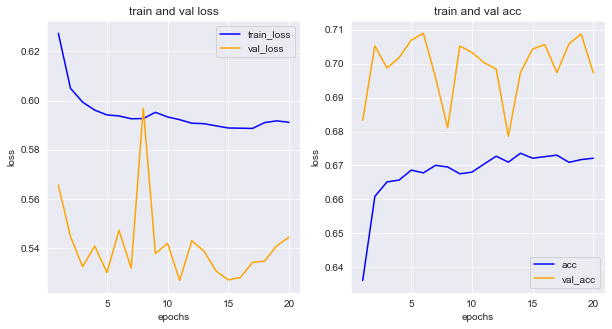

In [319]:
his_dict = history.history
loss = his_dict['loss']
val_loss = his_dict['val_loss'] # 검증 데이터가 있는 경우 val_ 수식어가 붙는다.

epochs = range(1,len(loss)+1 )
fig = plt.figure(figsize= (10,5) )

# 학습 및 검증 손실 그리기

ax1 = fig.add_subplot(1,2,1)
ax1.plot(epochs, loss, color = 'blue', label = 'train_loss')
ax1.plot(epochs, val_loss, color = 'orange', label = 'val_loss')
ax1.set_title('train and val loss')
ax1.set_xlabel('epochs')
ax1.set_ylabel('loss')
ax1.legend()

acc = his_dict['acc']
val_acc = his_dict['val_acc']

# 학습 및 검증 정확도 그리기
ax2 = fig.add_subplot(1,2,2)
ax2.plot(epochs, acc, color = 'blue', label = 'acc')
ax2.plot(epochs, val_acc, color = 'orange', label = 'val_acc')
ax2.set_title('train and val acc')
ax2.set_xlabel('epochs')
ax2.set_ylabel('loss')
ax2.legend()

plt.show()

In [320]:
model_acc=model.evaluate(x_test, y_test, verbose=0)[1]
model_acc

0.6973134875297546

In [321]:
y_pred=model.predict(x_test)

In [322]:
df_y_pred=pd.DataFrame(data=y_pred, columns=["target"])
df_y_pred["target"]=df_y_pred["target"].apply(lambda x:1 if x>=0.5 else 0)
f_1=f1_score(y_test, df_y_pred)

In [324]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test, df_y_pred)

array([[35361, 14756],
       [15631, 34643]], dtype=int64)

In [325]:
from sklearn.metrics import classification_report
auc_roc=classification_report(y_test, df_y_pred)
print(auc_roc)

              precision    recall  f1-score   support

           0       0.69      0.71      0.70     50117
           1       0.70      0.69      0.70     50274

    accuracy                           0.70    100391
   macro avg       0.70      0.70      0.70    100391
weighted avg       0.70      0.70      0.70    100391



In [327]:
model.save('C:/Users/bella/Desktop/SelfStudy/데이콘/Jobcare_data/model/my_model_1.h5')

CATBOOST StratifiedKFold
--

In [6]:
x=train.drop(['match_yn', 'match_yn_d', 'match_yn_h',"target"], axis=1)
y=train[["target"]]
x_train, x_test, y_train, y_test=train_test_split(x, y, test_size=0.2, random_state=42)

In [ ]:
cb.fit(x_train, y_train)
y_pred=cb.predict(x_test)
train_score=cb.score(x_train, y_train)
test_score=cb.score(x_test, y_test)
f_1=f1_score(y_test, y_pred)

In [8]:
from sklearn.model_selection import StratifiedKFold

n_fold=10
skf=StratifiedKFold(n_splits=n_fold, shuffle=True, random_state=42)

In [12]:
x_train=x_train.reset_index()
y_train=y_train.reset_index()
x_train.drop("index", axis=1, inplace=True)
y_train.drop("index", axis=1, inplace=True)

In [23]:
%%time
f1_list=[]
cnt=0

for train_idx, val_idx in skf.split(x_train, y_train):
    cnt+=1
    x_tn, x_val=x_train.loc[train_idx], x_train.loc[val_idx]
    y_tn, y_val=y_train.loc[train_idx], y_train.loc[val_idx]
    cb.fit(x_tn, y_tn)
    pred=cb.predict(x_val)
    f_1=f1_score(y_val, pred)
    f1_list.append(f_1)
    print("-------------------------------------")
    print(f"교차검증횟수 {cnt}")
    print(f"f1_score {f_1}")

In [20]:
print(f1_list)

[0.6838903145814711, 0.6819795123358823, 0.6827081586025393, 0.6825030306528892, 0.6861027886609818, 0.6850914528931324, 0.6812876451770944, 0.6760098450846966, 0.6798197469524524, 0.6805699780777663]


In [21]:
y_pred=cb.predict(x_test)
f_1=f1_score(y_test, y_pred)

In [22]:
print(f"f1_score: {f_1}")

f1_score: 0.6831541878610721


TEST_SCORE도 똑같이 다듬어주고 모델링해서 실제로 제출해보기
--

In [139]:
train=pd.read_csv("C:/Users/bella/Desktop/SelfStudy/데이콘/Jobcare_data/train_1.csv")

In [140]:
test=pd.read_csv("C:/Users/bella/Desktop/SelfStudy/데이콘/Jobcare_data/test.csv", parse_dates=["contents_open_dt"])
D=pd.read_csv("C:/Users/bella/Desktop/SelfStudy/데이콘/Jobcare_data/속성_D_코드.csv")
H=pd.read_csv("C:/Users/bella/Desktop/SelfStudy/데이콘/Jobcare_data/속성_H_코드.csv")
L=pd.read_csv("C:/Users/bella/Desktop/SelfStudy/데이콘/Jobcare_data/속성_L_코드.csv")
sub=pd.read_csv("C:/Users/bella/Desktop/SelfStudy/데이콘/Jobcare_data/sample_submission.csv")

In [141]:
train

,id,d_l_match_yn,d_m_match_yn,d_s_match_yn,h_l_match_yn,h_m_match_yn,h_s_match_yn,person_attribute_a,person_attribute_a_1,person_attribute_b,...,속성 D 소분류코드_y,속성 D 중분류코드_y,속성 D 대분류코드_y,속성 H 중분류코드_y,속성 H 대분류코드_y,속성 L 코드,속성 L 세분류코드,속성 L 소분류코드,속성 L 중분류코드,속성 L 대분류코드
0,0,1,1,1,2,2,2,1,4,3,...,274,274,216,422,94,1608,1607,1606,1605,2016
1,331621,1,1,1,2,2,2,1,7,3,...,274,274,216,422,94,1608,1607,1606,1605,2016
2,133244,1,1,1,2,2,2,1,6,5,...,274,274,216,422,94,1608,1607,1606,1605,2016
3,37130,2,2,2,1,1,1,1,4,2,...,274,274,216,422,94,1608,1607,1606,1605,2016
4,202316,1,2,2,1,2,2,1,3,4,...,274,274,216,422,94,1608,1607,1606,1605,2016
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
501946,461455,2,2,2,2,2,2,2,0,3,...,677,659,618,444,149,1863,1863,1853,1852,2021
501947,352731,1,1,1,2,2,2,1,6,2,...,847,824,744,490,208,67,67,67,67,2005
501948,224676,1,1,1,2,2,2,1,4,2,...,847,824,744,490,208,67,67,67,67,2005
501949,313755,2,2,2,1,2,2,2,6,2,...,847,824,744,490,208,67,67,67,67,2005


In [142]:
test.isna().sum()

id                        0
d_l_match_yn              0
d_m_match_yn              0
d_s_match_yn              0
h_l_match_yn              0
h_m_match_yn              0
h_s_match_yn              0
person_attribute_a        0
person_attribute_a_1      0
person_attribute_b        0
person_prefer_c           0
person_prefer_d_1         0
person_prefer_d_2         0
person_prefer_d_3         0
person_prefer_e           0
person_prefer_f           0
person_prefer_g           0
person_prefer_h_1         0
person_prefer_h_2         0
person_prefer_h_3         0
contents_attribute_i      0
contents_attribute_a      0
contents_attribute_j_1    0
contents_attribute_j      0
contents_attribute_c      0
contents_attribute_k      0
contents_attribute_l      0
contents_attribute_d      0
contents_attribute_m      0
contents_attribute_e      0
contents_attribute_h      0
person_rn                 0
contents_rn               0
contents_open_dt          0
dtype: int64

In [143]:
for i in range(1,7):
    name=test.columns[i]
    test[name]=test[name].apply(lambda x:1 if x==True else 2)

In [144]:
test["time"]=test["contents_open_dt"].dt.strftime("%m%d%H")
test["month"]=test["contents_open_dt"].dt.strftime("%m")
test["date"]=test["contents_open_dt"].dt.strftime("%d")
test["hour"]=test["contents_open_dt"].dt.strftime("%H")
test["day"]=test["contents_open_dt"].dt.strftime("%A")

test["time"]=test["time"].astype(int)
test["month"]=test["month"].astype(int)
test["date"]=test["date"].astype(int)
test["hour"]=test["hour"].astype(int)

In [145]:
test["속성 D 코드"]=test["contents_attribute_d"]
test["속성 H 코드"]=test["contents_attribute_h"]
test["속성 L 코드"]=test["contents_attribute_l"]

test=pd.merge(test, D, how='inner', on='속성 D 코드')
test=pd.merge(test, H, how='inner', on='속성 H 코드')
test=pd.merge(test, L, how='inner', on='속성 L 코드')

In [146]:
train.drop(['match_yn', 'match_yn_d', 'match_yn_h'], axis=1, inplace=True)

In [147]:
set(train.columns)-set(test.columns)

{'target',
 '속성 D 대분류코드_x',
 '속성 D 대분류코드_y',
 '속성 D 세분류코드_x',
 '속성 D 세분류코드_y',
 '속성 D 소분류코드_x',
 '속성 D 소분류코드_y',
 '속성 D 중분류코드_x',
 '속성 D 중분류코드_y',
 '속성 H 대분류코드_x',
 '속성 H 대분류코드_y',
 '속성 H 중분류코드_x',
 '속성 H 중분류코드_y'}

In [148]:
train_2=train.copy()
train_2.drop(['속성 D 대분류코드_x',
 '속성 D 대분류코드_y',
 '속성 D 세분류코드_x',
 '속성 D 세분류코드_y',
 '속성 D 소분류코드_x',
 '속성 D 소분류코드_y',
 '속성 D 중분류코드_x',
 '속성 D 중분류코드_y',
 '속성 H 대분류코드_x',
 '속성 H 대분류코드_y',
 '속성 H 중분류코드_x',
 '속성 H 중분류코드_y'], axis=1, inplace=True)

In [149]:
test.drop("contents_open_dt", axis=1, inplace=True)

In [150]:
from sklearn.preprocessing import LabelEncoder
le=LabelEncoder()

test["day"]=le.fit_transform(test["day"])

In [151]:
x_train=train_2.drop('target', axis=1)
y_train=train_2["target"]

In [152]:
cb = CatBoostClassifier(random_state=42)

In [166]:
cb.fit(x_train, y_train)
y_pred=cb.predict(x_train)
train_score=cb.score(x_train, y_train)
f_1=f1_score(y_train, y_pred)

In [154]:
print("train_score", train_score)
print("f1_score", f_1)

train_score 0.751740707758327
f1_score 0.7140818377470527


In [155]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_train, y_pred)

array([[221725,  29381],
       [ 95233, 155612]], dtype=int64)

In [156]:
from sklearn.metrics import classification_report
auc_roc=classification_report(y_train, y_pred)
print(auc_roc)

              precision    recall  f1-score   support

           0       0.70      0.88      0.78    251106
           1       0.84      0.62      0.71    250845

    accuracy                           0.75    501951
   macro avg       0.77      0.75      0.75    501951
weighted avg       0.77      0.75      0.75    501951



In [157]:
pred=cb.predict(test)

In [158]:
pred

array([0, 0, 0, ..., 1, 0, 1], dtype=int64)

In [159]:
sub

,id,target
0,0,0
1,1,0
2,2,0
3,3,0
4,4,0
...,...,...
46399,46399,0
46400,46400,0
46401,46401,0
46402,46402,0


In [160]:
df_pred=pd.DataFrame(pred, columns=['target'])

In [161]:
sub.drop("target", axis=1, inplace=True)

In [162]:
sub=pd.concat([sub, df_pred], axis=1)

In [163]:
sub

,id,target
0,0,0
1,1,0
2,2,0
3,3,0
4,4,0
...,...,...
46399,46399,0
46400,46400,0
46401,46401,1
46402,46402,0


In [164]:
#sub.to_csv("C:/Users/bella/Desktop/SelfStudy/데이콘/Jobcare_data/sub_2.csv", index=False)

<AxesSubplot:xlabel='target', ylabel='count'>

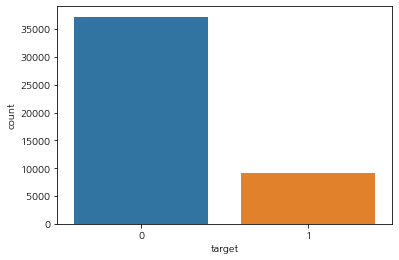

In [165]:
import seaborn

sns.countplot(sub['target'])

To be continue
--